In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchPositionEmbedding(nn.Module):
    def __init__(self, img_size=224, in_channels=3, patch_size=16, emb_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2
        self.conv2d = nn.Conv2d(in_channels=in_channels, out_channels=emb_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten = nn.Flatten(start_dim=-2, end_dim=-1)
        self.cls_tokens = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_embs = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))

    def forward(self, x):
        x = self.conv2d(x)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)
        batch_size = x.shape[0]
        cls_tokens = self.cls_tokens.expand(batch_size, -1, -1)
        pos_embs = self.pos_embs.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        return x + pos_embs

class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, emb_dim=768, num_heads=12, attn_dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(emb_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=emb_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        x, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return x

class MLPBlock(nn.Module):
    def __init__(self, emb_dim=768, mlp_size=3072, dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_size, emb_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        return self.mlp(x)

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_dim=768, num_heads=12, attn_dropout=0.0, mlp_size=3072, dropout=0.1):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(emb_dim, num_heads, attn_dropout)
        self.mlp_block = MLPBlock(emb_dim, mlp_size, dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, in_channels=3, patch_size=16, emb_dim=768, emb_dropout=0.1,
                 num_transformer_layers=12, num_heads=12, attn_dropout=0.0, mlp_size=3072, dropout=0.1,
                 num_classes=6):
        super().__init__()
        self.pat_pos_emb = PatchPositionEmbedding(img_size, in_channels, patch_size, emb_dim)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.encoder = nn.Sequential(
            *[TransformerEncoderBlock(emb_dim, num_heads, attn_dropout, mlp_size, dropout)
              for _ in range(num_transformer_layers)]
        )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, x):
        x = self.pat_pos_emb(x)
        x = self.emb_dropout(x)
        x = self.encoder(x)
        x = x[:, 0, :]
        return self.mlp_head(x)

class MixupCutmix:
    def __init__(self, mixup_alpha=0.8, cutmix_alpha=1.0, prob=1.0, switch_prob=0.5):
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.prob = prob
        self.switch_prob = switch_prob

    def _rand_bbox(self, W, H, lam, device):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = (W * cut_rat).int()
        cut_h = (H * cut_rat).int()

        cx = torch.randint(0, W, (1,), device=device)
        cy = torch.randint(0, H, (1,), device=device)

        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)

        return x1.item(), y1.item(), x2.item(), y2.item()

    def __call__(self, images, labels):
        labels = F.one_hot(torch.tensor(labels), num_classes=6).float()
        if torch.rand(1).item() > self.prob:
            return images, labels

        device = images.device
        batch_size = images.size(0)

        indices = torch.randperm(batch_size, device=device)

        x1 = images
        x2 = images[indices]
        y1 = labels
        y2 = labels[indices]

        # ---------------- MIXUP ----------------
        if torch.rand(1).item() < self.switch_prob:
            lam = torch.distributions.Beta(self.mixup_alpha, self.mixup_alpha).sample().to(device)
            images = lam * x1 + (1 - lam) * x2

        # ---------------- CUTMIX ----------------
        else:
            lam = torch.distributions.Beta(self.cutmix_alpha, self.cutmix_alpha).sample().to(device)

            W = images.size(3)
            H = images.size(2)
            x1b, y1b, x2b, y2b = self._rand_bbox(W, H, lam, device)

            images[:, :, y1b:y2b, x1b:x2b] = x2[:, :, y1b:y2b, x1b:x2b]

            lam = 1 - ((x2b - x1b) * (y2b - y1b) / (W * H))

        labels = lam * y1 + (1 - lam) * y2
        return images, labels



🔹 Epoch 1/80


💾 Saved best model (val acc: 55.63%) to '../models/vit_best_model.pth'
✅ Epoch 1/80 -- Train Loss: 1.2125, Train Acc: 50.12% | Val Loss: 1.0622, Val Acc: 55.63%

🔹 Epoch 2/80


💾 Saved best model (val acc: 63.62%) to '../models/vit_best_model.pth'
✅ Epoch 2/80 -- Train Loss: 0.9692, Train Acc: 60.85% | Val Loss: 0.9064, Val Acc: 63.62%

🔹 Epoch 3/80


✅ Epoch 3/80 -- Train Loss: 0.9185, Train Acc: 63.68% | Val Loss: 0.9307, Val Acc: 61.73%

🔹 Epoch 4/80


💾 Saved best model (val acc: 66.33%) to '../models/vit_best_model.pth'
✅ Epoch 4/80 -- Train Loss: 0.8939, Train Acc: 64.08% | Val Loss: 0.8486, Val Acc: 66.33%

🔹 Epoch 5/80


💾 Saved best model (val acc: 66.80%) to '../models/vit_best_model.pth'
✅ Epoch 5/80 -- Train Loss: 0.8675, Train Acc: 65.34% | Val Loss: 0.8344, Val Acc: 66.80%

🔹 Epoch 6/80


✅ Epoch 6/80 -- Train Loss: 0.8559, Train Acc: 65.77% | Val Loss: 0.8358, Val Acc: 66.48%

🔹 Epoch 7/80


💾 Saved best model (val acc: 69.01%) to '../models/vit_best_model.pth'
✅ Epoch 7/80 -- Train Loss: 0.8412, Train Acc: 66.52% | Val Loss: 0.7768, Val Acc: 69.01%

🔹 Epoch 8/80


💾 Saved best model (val acc: 69.69%) to '../models/vit_best_model.pth'
✅ Epoch 8/80 -- Train Loss: 0.8216, Train Acc: 67.59% | Val Loss: 0.7897, Val Acc: 69.69%

🔹 Epoch 9/80


✅ Epoch 9/80 -- Train Loss: 0.8098, Train Acc: 68.07% | Val Loss: 0.7607, Val Acc: 69.29%

🔹 Epoch 10/80


✅ Epoch 10/80 -- Train Loss: 0.7848, Train Acc: 69.04% | Val Loss: 0.8062, Val Acc: 67.51%

🔹 Epoch 11/80


✅ Epoch 11/80 -- Train Loss: 0.7812, Train Acc: 68.69% | Val Loss: 0.8188, Val Acc: 67.12%

🔹 Epoch 12/80


💾 Saved best model (val acc: 71.50%) to '../models/vit_best_model.pth'
✅ Epoch 12/80 -- Train Loss: 0.7687, Train Acc: 69.61% | Val Loss: 0.7114, Val Acc: 71.50%

🔹 Epoch 13/80


💾 Saved best model (val acc: 72.61%) to '../models/vit_best_model.pth'
✅ Epoch 13/80 -- Train Loss: 0.7506, Train Acc: 70.45% | Val Loss: 0.6895, Val Acc: 72.61%

🔹 Epoch 14/80


💾 Saved best model (val acc: 73.32%) to '../models/vit_best_model.pth'
✅ Epoch 14/80 -- Train Loss: 0.7339, Train Acc: 70.81% | Val Loss: 0.6956, Val Acc: 73.32%

🔹 Epoch 15/80


✅ Epoch 15/80 -- Train Loss: 0.7108, Train Acc: 72.22% | Val Loss: 0.6905, Val Acc: 73.11%

🔹 Epoch 16/80


💾 Saved best model (val acc: 75.32%) to '../models/vit_best_model.pth'
✅ Epoch 16/80 -- Train Loss: 0.7017, Train Acc: 72.73% | Val Loss: 0.6553, Val Acc: 75.32%

🔹 Epoch 17/80


✅ Epoch 17/80 -- Train Loss: 0.6881, Train Acc: 72.91% | Val Loss: 0.7309, Val Acc: 72.54%

🔹 Epoch 18/80


✅ Epoch 18/80 -- Train Loss: 0.6800, Train Acc: 73.61% | Val Loss: 0.6729, Val Acc: 74.11%

🔹 Epoch 19/80


✅ Epoch 19/80 -- Train Loss: 0.6652, Train Acc: 74.26% | Val Loss: 0.6423, Val Acc: 74.57%

🔹 Epoch 20/80


✅ Epoch 20/80 -- Train Loss: 0.6638, Train Acc: 74.00% | Val Loss: 0.6526, Val Acc: 74.71%

🔹 Epoch 21/80


💾 Saved best model (val acc: 76.68%) to '../models/vit_best_model.pth'
✅ Epoch 21/80 -- Train Loss: 0.6467, Train Acc: 74.93% | Val Loss: 0.6053, Val Acc: 76.68%

🔹 Epoch 22/80


✅ Epoch 22/80 -- Train Loss: 0.6374, Train Acc: 75.49% | Val Loss: 0.6066, Val Acc: 76.39%

🔹 Epoch 23/80


✅ Epoch 23/80 -- Train Loss: 0.6303, Train Acc: 75.54% | Val Loss: 0.6288, Val Acc: 74.86%

🔹 Epoch 24/80


💾 Saved best model (val acc: 76.93%) to '../models/vit_best_model.pth'
✅ Epoch 24/80 -- Train Loss: 0.6154, Train Acc: 76.06% | Val Loss: 0.5963, Val Acc: 76.93%

🔹 Epoch 25/80


✅ Epoch 25/80 -- Train Loss: 0.6076, Train Acc: 76.52% | Val Loss: 0.6272, Val Acc: 76.18%

🔹 Epoch 26/80


✅ Epoch 26/80 -- Train Loss: 0.5923, Train Acc: 77.43% | Val Loss: 0.5818, Val Acc: 76.89%

🔹 Epoch 27/80


💾 Saved best model (val acc: 77.43%) to '../models/vit_best_model.pth'
✅ Epoch 27/80 -- Train Loss: 0.5761, Train Acc: 77.82% | Val Loss: 0.5796, Val Acc: 77.43%

🔹 Epoch 28/80


💾 Saved best model (val acc: 78.64%) to '../models/vit_best_model.pth'
✅ Epoch 28/80 -- Train Loss: 0.5685, Train Acc: 78.41% | Val Loss: 0.5577, Val Acc: 78.64%

🔹 Epoch 29/80


✅ Epoch 29/80 -- Train Loss: 0.5625, Train Acc: 78.48% | Val Loss: 0.5832, Val Acc: 77.92%

🔹 Epoch 30/80


✅ Epoch 30/80 -- Train Loss: 0.5514, Train Acc: 79.14% | Val Loss: 0.5671, Val Acc: 78.28%

🔹 Epoch 31/80


💾 Saved best model (val acc: 79.21%) to '../models/vit_best_model.pth'
✅ Epoch 31/80 -- Train Loss: 0.5453, Train Acc: 78.91% | Val Loss: 0.5661, Val Acc: 79.21%

🔹 Epoch 32/80


✅ Epoch 32/80 -- Train Loss: 0.5320, Train Acc: 79.37% | Val Loss: 0.6038, Val Acc: 78.28%

🔹 Epoch 33/80


💾 Saved best model (val acc: 80.74%) to '../models/vit_best_model.pth'
✅ Epoch 33/80 -- Train Loss: 0.5154, Train Acc: 80.13% | Val Loss: 0.5318, Val Acc: 80.74%

🔹 Epoch 34/80


✅ Epoch 34/80 -- Train Loss: 0.5122, Train Acc: 80.69% | Val Loss: 0.5591, Val Acc: 79.07%

🔹 Epoch 35/80


✅ Epoch 35/80 -- Train Loss: 0.5064, Train Acc: 80.30% | Val Loss: 0.5246, Val Acc: 79.42%

🔹 Epoch 36/80


✅ Epoch 36/80 -- Train Loss: 0.4915, Train Acc: 81.44% | Val Loss: 0.5472, Val Acc: 78.92%

🔹 Epoch 37/80


✅ Epoch 37/80 -- Train Loss: 0.4775, Train Acc: 81.63% | Val Loss: 0.5694, Val Acc: 79.46%

🔹 Epoch 38/80


✅ Epoch 38/80 -- Train Loss: 0.4638, Train Acc: 82.30% | Val Loss: 0.5261, Val Acc: 80.49%

🔹 Epoch 39/80


✅ Epoch 39/80 -- Train Loss: 0.4662, Train Acc: 82.10% | Val Loss: 0.5143, Val Acc: 80.60%

🔹 Epoch 40/80


💾 Saved best model (val acc: 81.21%) to '../models/vit_best_model.pth'
✅ Epoch 40/80 -- Train Loss: 0.4556, Train Acc: 82.64% | Val Loss: 0.5168, Val Acc: 81.21%

🔹 Epoch 41/80


✅ Epoch 41/80 -- Train Loss: 0.4394, Train Acc: 83.19% | Val Loss: 0.5125, Val Acc: 81.10%

🔹 Epoch 42/80


💾 Saved best model (val acc: 81.42%) to '../models/vit_best_model.pth'
✅ Epoch 42/80 -- Train Loss: 0.4353, Train Acc: 83.18% | Val Loss: 0.5199, Val Acc: 81.42%

🔹 Epoch 43/80


✅ Epoch 43/80 -- Train Loss: 0.4157, Train Acc: 84.18% | Val Loss: 0.5088, Val Acc: 80.96%

🔹 Epoch 44/80


💾 Saved best model (val acc: 81.63%) to '../models/vit_best_model.pth'
✅ Epoch 44/80 -- Train Loss: 0.4151, Train Acc: 83.80% | Val Loss: 0.5166, Val Acc: 81.63%

🔹 Epoch 45/80


✅ Epoch 45/80 -- Train Loss: 0.4011, Train Acc: 84.36% | Val Loss: 0.5088, Val Acc: 81.13%

🔹 Epoch 46/80


✅ Epoch 46/80 -- Train Loss: 0.4024, Train Acc: 84.50% | Val Loss: 0.5172, Val Acc: 80.81%

🔹 Epoch 47/80


💾 Saved best model (val acc: 81.67%) to '../models/vit_best_model.pth'
✅ Epoch 47/80 -- Train Loss: 0.3809, Train Acc: 85.50% | Val Loss: 0.4968, Val Acc: 81.67%

🔹 Epoch 48/80


✅ Epoch 48/80 -- Train Loss: 0.3729, Train Acc: 85.70% | Val Loss: 0.5102, Val Acc: 81.42%

🔹 Epoch 49/80


💾 Saved best model (val acc: 82.38%) to '../models/vit_best_model.pth'
✅ Epoch 49/80 -- Train Loss: 0.3655, Train Acc: 86.04% | Val Loss: 0.5020, Val Acc: 82.38%

🔹 Epoch 50/80


✅ Epoch 50/80 -- Train Loss: 0.3594, Train Acc: 86.08% | Val Loss: 0.5123, Val Acc: 81.88%

🔹 Epoch 51/80


✅ Epoch 51/80 -- Train Loss: 0.3337, Train Acc: 87.12% | Val Loss: 0.5148, Val Acc: 82.28%

🔹 Epoch 52/80


✅ Epoch 52/80 -- Train Loss: 0.3344, Train Acc: 87.14% | Val Loss: 0.5047, Val Acc: 81.38%

🔹 Epoch 53/80


✅ Epoch 53/80 -- Train Loss: 0.3148, Train Acc: 87.89% | Val Loss: 0.4954, Val Acc: 82.28%

🔹 Epoch 54/80


✅ Epoch 54/80 -- Train Loss: 0.3095, Train Acc: 87.98% | Val Loss: 0.5035, Val Acc: 81.99%

🔹 Epoch 55/80


💾 Saved best model (val acc: 83.13%) to '../models/vit_best_model.pth'
✅ Epoch 55/80 -- Train Loss: 0.3066, Train Acc: 88.19% | Val Loss: 0.4920, Val Acc: 83.13%

🔹 Epoch 56/80


💾 Saved best model (val acc: 83.31%) to '../models/vit_best_model.pth'
✅ Epoch 56/80 -- Train Loss: 0.3018, Train Acc: 88.50% | Val Loss: 0.4910, Val Acc: 83.31%

🔹 Epoch 57/80


✅ Epoch 57/80 -- Train Loss: 0.2822, Train Acc: 89.03% | Val Loss: 0.5088, Val Acc: 82.67%

🔹 Epoch 58/80


✅ Epoch 58/80 -- Train Loss: 0.2709, Train Acc: 89.47% | Val Loss: 0.4909, Val Acc: 82.95%

🔹 Epoch 59/80


✅ Epoch 59/80 -- Train Loss: 0.2666, Train Acc: 89.87% | Val Loss: 0.5258, Val Acc: 82.74%

🔹 Epoch 60/80


✅ Epoch 60/80 -- Train Loss: 0.2625, Train Acc: 90.07% | Val Loss: 0.5177, Val Acc: 82.56%

🔹 Epoch 61/80


✅ Epoch 61/80 -- Train Loss: 0.2533, Train Acc: 90.36% | Val Loss: 0.5124, Val Acc: 82.49%

🔹 Epoch 62/80


✅ Epoch 62/80 -- Train Loss: 0.2466, Train Acc: 90.64% | Val Loss: 0.5191, Val Acc: 82.77%

🔹 Epoch 63/80


✅ Epoch 63/80 -- Train Loss: 0.2372, Train Acc: 91.01% | Val Loss: 0.5261, Val Acc: 82.85%

🔹 Epoch 64/80


✅ Epoch 64/80 -- Train Loss: 0.2268, Train Acc: 91.75% | Val Loss: 0.5313, Val Acc: 82.77%

🔹 Epoch 65/80


✅ Epoch 65/80 -- Train Loss: 0.2164, Train Acc: 91.68% | Val Loss: 0.5446, Val Acc: 82.28%

🔹 Epoch 66/80


✅ Epoch 66/80 -- Train Loss: 0.2113, Train Acc: 91.68% | Val Loss: 0.5525, Val Acc: 82.42%

🔹 Epoch 67/80


✅ Epoch 67/80 -- Train Loss: 0.2191, Train Acc: 91.76% | Val Loss: 0.5408, Val Acc: 82.20%

🔹 Epoch 68/80


✅ Epoch 68/80 -- Train Loss: 0.1996, Train Acc: 92.40% | Val Loss: 0.5509, Val Acc: 82.56%

🔹 Epoch 69/80


✅ Epoch 69/80 -- Train Loss: 0.1982, Train Acc: 92.40% | Val Loss: 0.5550, Val Acc: 82.31%

🔹 Epoch 70/80


✅ Epoch 70/80 -- Train Loss: 0.1951, Train Acc: 92.64% | Val Loss: 0.5565, Val Acc: 82.67%

🔹 Epoch 71/80


✅ Epoch 71/80 -- Train Loss: 0.1928, Train Acc: 92.86% | Val Loss: 0.5596, Val Acc: 81.81%

🔹 Epoch 72/80


✅ Epoch 72/80 -- Train Loss: 0.1855, Train Acc: 93.13% | Val Loss: 0.5598, Val Acc: 82.42%

🔹 Epoch 73/80


✅ Epoch 73/80 -- Train Loss: 0.1928, Train Acc: 92.88% | Val Loss: 0.5718, Val Acc: 82.52%

🔹 Epoch 74/80


✅ Epoch 74/80 -- Train Loss: 0.1888, Train Acc: 92.84% | Val Loss: 0.5640, Val Acc: 82.20%

🔹 Epoch 75/80


✅ Epoch 75/80 -- Train Loss: 0.1847, Train Acc: 93.18% | Val Loss: 0.5657, Val Acc: 82.49%

🔹 Epoch 76/80


✅ Epoch 76/80 -- Train Loss: 0.1797, Train Acc: 93.28% | Val Loss: 0.5745, Val Acc: 82.49%

🔹 Epoch 77/80


✅ Epoch 77/80 -- Train Loss: 0.1832, Train Acc: 93.05% | Val Loss: 0.5649, Val Acc: 82.42%

🔹 Epoch 78/80


✅ Epoch 78/80 -- Train Loss: 0.1743, Train Acc: 93.50% | Val Loss: 0.5653, Val Acc: 82.45%

🔹 Epoch 79/80


✅ Epoch 79/80 -- Train Loss: 0.1832, Train Acc: 93.01% | Val Loss: 0.5661, Val Acc: 82.31%

🔹 Epoch 80/80


✅ Epoch 80/80 -- Train Loss: 0.1750, Train Acc: 93.63% | Val Loss: 0.5659, Val Acc: 82.35%

🎯 Training complete. Best Val Acc: 83.31%
Test Loss: 0.5325
Test Accuracy: 81.80%

Classification Report:
              precision    recall  f1-score   support

   buildings       0.80      0.74      0.77       437
      forest       0.94      0.96      0.95       474
     glacier       0.85      0.70      0.77       553
    mountain       0.77      0.80      0.78       525
         sea       0.76      0.89      0.82       510
      street       0.80      0.82      0.81       501

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



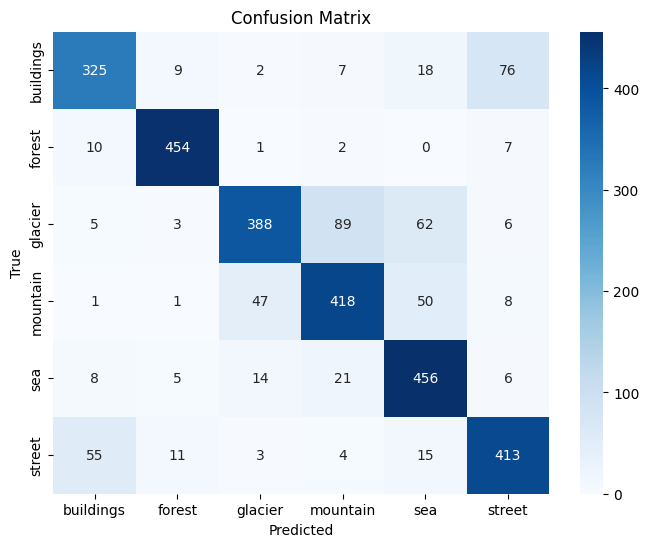

In [ ]:
import sys
sys.path.insert(0, '/datastore/cndt_hangdv/music-project/style_transfer/lab04/src')
import importlib
import dataset
import train
importlib.reload(dataset)
importlib.reload(train)
from dataset import loader_dict, dataset_dict
from train import train_model, test_model

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
vit = VisionTransformer(
    patch_size=16,
    num_classes=6,
    emb_dim=384,
    mlp_size=384*4,
    num_heads=6,               
    num_transformer_layers=10  
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    vit.parameters(),
    lr=3e-4,
    weight_decay=0.05,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)
save_path = '../models/vit.pth'
class_names = dataset_dict['train'].class_names
train_model(vit, loader_dict, dataset_dict, num_epochs=80, criterion=criterion, optimizer=optimizer, device=device, save_path=save_path, scheduler=scheduler)
test_model(save_path, vit, loader_dict['test'], dataset_dict['test'], criterion, device, class_names)
